# Unet Trainer

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator, FLX_Cumulative_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FLX_Cumulative_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
#D = [Load_FLX_dict('DictPrepross2.hdf5')]
#normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size*500, custom_b_p_e=100)
#D[0].fitonGen(normal_generator, axis=1)
#del(normal_generator)

In [3]:
#X = D[0].to_array_save()
#X.to_hdf('DictPrepross2.hdf5', key='s')

In [4]:
#X = D[0].to_array_save()
#D[0].to_hdf('DictPrepross2.hdf5', key='s')

In [5]:
##### Kernels
D=[Load_FLX_dict('DictPrepross2.hdf5')]
def Bin(x): 
    x[np.where(x!=0)] = 1
#    x[np.where(x==0)] = 0
    return(x)

Klist0 = []
Klist =[]# FKernel(identity, ['ql']), FKernel(identity, ['qi']) ]

D2 = [DictPrepross(['o3','pl','q'], 
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]

fit_genator =FLX_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
fit_genator.max_b=50
D2[0].fitonGen(fit_genator, axis=2)
del(fit_genator)

Restart - to file 0


In [6]:
# V
V = [VarSuppression(['ts'])]#, 'frocean', 'frlake','frland','frlandice', 'frseaice'])]

##### Full Preprocessing :
FP = D + Klist + V #D2 + V
FP2 = D + Klist + D2 + V

##### b_size
train_generator =  FLX_Cumulative_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1, custom_b_p_e=3888)
validation_generator = FLX_Cumulative_Generator(folder='Data3', batch_size=batch_size, train=False, preprocess_x=FP, shuffle=0)
validation_generator.max_b=500
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = ['flx']#train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

Restart - to file 0
Restart - to file 0


In [7]:
#train_generator._div = train_generator._div - 1
#train_generator.idx_file=np.arange(train_generator._div)
#validation_generator._div = 1
#validation_generator.idx_file=np.array([train_generator._div])

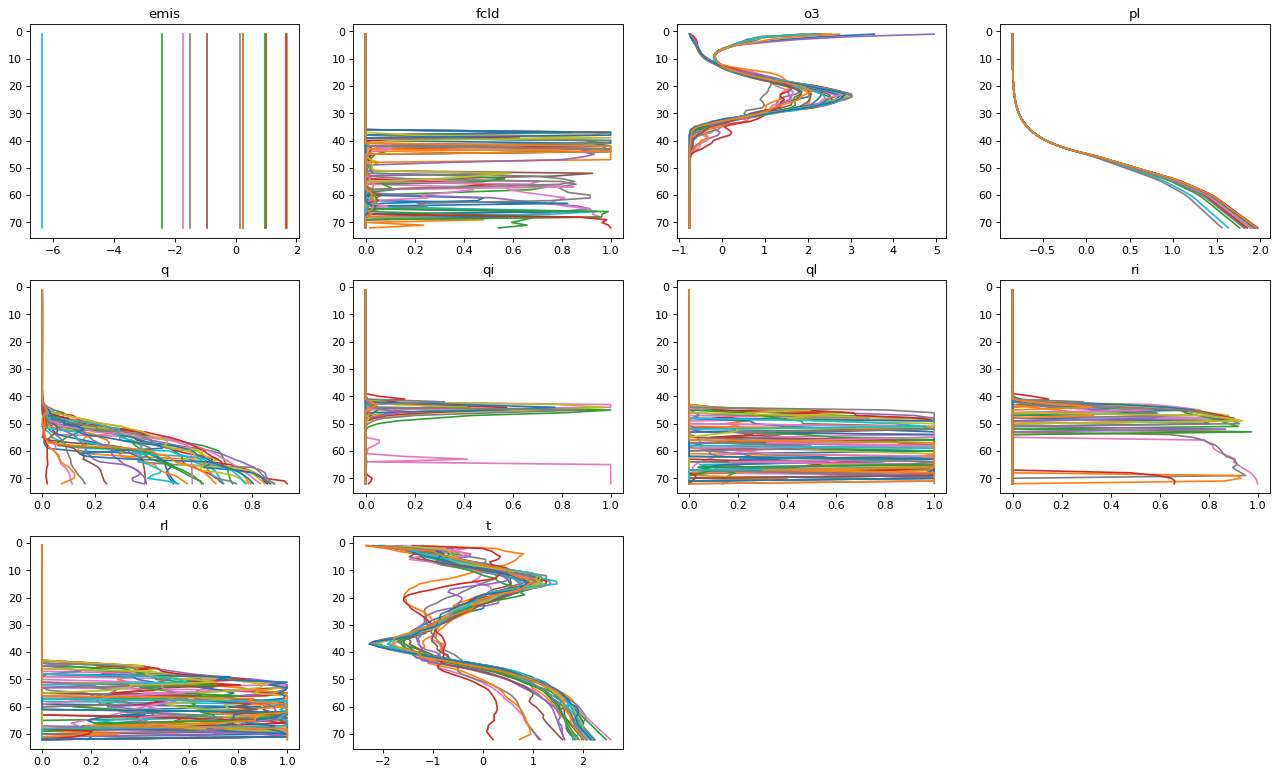

In [ ]:
x,y = train_generator[0]
Plot_Batch(x,header_x)

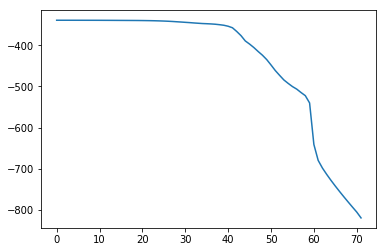

In [ ]:
plt.plot(-y[0,1:]-y[0,0]);

In [ ]:
from generator import FLX_Diff_Bias_Generator

In [ ]:
from generator import FLX_Cumulative_Generator,FLX_Diff_Bias_Generator
P = FLX_Diff_Bias_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0,shuffle=0, custom_b_p_e=0)
P2 = FLX_Cumulative_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0,shuffle=0, custom_b_p_e=0)
x,y = P[0]
x1,y1 = P2[0]

Restart - to file 0
Restart - to file 0


In [ ]:
plt.plot(np.cumsum(y[0,1:]))
plt.plot(y1[0,1:])

In [ ]:
y[0,0], y1[0,0]

In [ ]:
plt.plot(y[0,-1,1:]-y[0,-2,1:]);
plt.plot(-y1[0,1:]-y1[0,0]);

### Model construct

In [13]:
from CST import CST
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed, Concatenate
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D, MaxPooling1D
from keras.layers import Bidirectional, Lambda, Reshape, SpatialDropout1D,Dropout
from keras.losses import mean_squared_error
from keras import backend as K
from keras import regularizers
import tensorflow as tf
import os
import numpy as np
from contextlib import redirect_stdout
from CST import CST
from architectures_utils import Name, Activation_Generator

def Unet_Act_Cum(list_of_kernels_s, list_of_filters, list_of_activations, list_of_dropout, params=[], Div=3, lev=CST.lev(CST), in_channel=11, reg=0.001 ):
    """
    Generate a Unet-Archictecture:
    list_of_kernels : list of 3 lists containing the kernel size for convolution
    list_of_filters : list of 3 lists containing the number of filters for convolution
    list_of_activations : list of 3 list containing the names of the activation function
    list_of_dropout : list of 3 list containing the names of the dropout rate
    params : params used for activation
    Div : number of downscaling
    in_channel : number of inputs
    """
    AG = Activation_Generator()
    Sizes = [ len(list_of_filters[i]) for i in range(len(list_of_filters)) ]
#First Convolutions
    Conv_l0 = [Input(name='Origin_Input', dtype='float32', shape=(lev, in_channel))]
    for i in range(Sizes[0]):
        Conv_l0.append(Conv1D(filters=list_of_filters[0][i], kernel_size=list_of_kernels_s[0][i],
                            padding='same', use_bias=False, name=Name('Conv', i),
                            kernel_regularizer=regularizers.l1(reg))(Conv_l0[-1]))
        Conv_l0.append( AG(list_of_activations[0][i], Name(list_of_activations[0][i], i), params)(Conv_l0[-1]))
        Conv_l0.append( SpatialDropout1D(list_of_dropout[0][i])(Conv_l0[-1]))

# DownScaling
    Conv_l1 = [Conv_l0[-1]]
    for i in range(Sizes[1]//2):
        Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
        Conv_l1.append(Conv1D(filters=list_of_filters[1][2*i], kernel_size=list_of_kernels_s[1][2*i],
                               padding='same', name=Name('Conv', i+100))(Conv_l1[-1] ))
        Conv_l1.append(AG(list_of_activations[1][2*i], Name(list_of_activations[1][2*i], 100+i), params )(Conv_l1[-1]) )
        Conv_l1.append( SpatialDropout1D(list_of_dropout[1][2*i])(Conv_l1[-1]))

        Conv_l1.append(Conv1D(filters=list_of_filters[1][2*i+1], kernel_size=list_of_kernels_s[1][2*i+1],
                               padding='same', name=Name('Conv', 110+i))(Conv_l1[-1]) )
        Conv_l1.append(AG(list_of_activations[1][2*i+1], Name(list_of_activations[1][2*i+1], 110+i), params )(Conv_l1[-1]))
        Conv_l1.append( SpatialDropout1D(list_of_dropout[1][2*i+1])(Conv_l1[-1]))

# Operation done on the small dimension : here fc
    Conv_l2 = [(Conv_l1[-1])]
    for i in range(Sizes[2]):
        Conv_l2.append(Conv1D(filters=list_of_filters[2][i], kernel_size=int(lev/2**Div),
                               padding='same', name=Name('Dense', i))(Conv_l2[-1]))
        Conv_l2.append(AG(list_of_activations[2][i], list_of_activations[2][i]+'_d_'+str(i), params)(Conv_l2[-1]))
        Conv_l2.append( SpatialDropout1D(list_of_dropout[2][i])(Conv_l2[-1]))
    Conv_l3 = [Conv_l2[-1]]

# Upsampling and concats
    for i in range(Sizes[3]//2):
        Conv_l3.append( Concatenate( name=Name('Concat',i+300) )([Conv_l3[-1], Conv_l1[-(1+i*7)]]))
        Conv_l3.append(UpSampling1D(2, name=Name('Ups',i+200))(Conv_l3[-1]))
        Conv_l3.append(Conv1D(filters=list_of_filters[3][2*i], kernel_size=list_of_kernels_s[3][2*i], padding='same',
                               name=Name('Conv', i+200))(Conv_l3[-1] ))
        Conv_l3.append( AG(list_of_activations[3][2*i], Name(list_of_activations[3][2*i], 200+i), params )(Conv_l3[-1]) )
        Conv_l3.append( SpatialDropout1D(list_of_dropout[3][2*i])(Conv_l3[-1]))

        Conv_l3.append(Conv1D(filters=list_of_filters[3][2*i+1], kernel_size=list_of_kernels_s[3][2*i+1], padding='same',
                               name=Name('Conv', i + 210))(Conv_l3[-1]))
        Conv_l3.append(AG(list_of_activations[3][2*i+1], Name(list_of_activations[3][2*i+1], 210 + i), params)(Conv_l3[-1]))
        Conv_l3.append( SpatialDropout1D(list_of_dropout[3][2*i+1])(Conv_l3[-1]))

# Last Conv layers
    Conv_l4 = [Conv_l3[-1]]
    for i in range(Sizes[4]):
        Conv_l4.append(Conv1D(filters=list_of_filters[4][i], kernel_size=list_of_kernels_s[4][i],
                            padding='same', use_bias=False, name=Name('Conv3',i+300),
                            kernel_regularizer=regularizers.l2(reg))(Conv_l4[-1]))
        Conv_l4.append( AG(list_of_activations[4][i], Name(list_of_activations[4][i], 300+i), params )(Conv_l4[-1]) )
        Conv_l4.append( SpatialDropout1D(list_of_dropout[4][i])(Conv_l4[-1]))

    # output of middle layer
    D_l = [Conv_l2[-1]]
    D_l.append(Flatten(name=Name('Flat', 0))(D_l))
    for i in range(Sizes[5]):
        D_l.append(Dense(units=list_of_filters[5][i], kernel_regularizer=regularizers.l2(reg), name=Name('Dense', 200+i))(D_l[-1]))
        D_l.append(AG(list_of_activations[5][i], list_of_activations[5][i]+'_d2_'+str(i), params)(D_l[-1]))
        D_l.append( Dropout(list_of_dropout[5][i])(D_l[-1]))

    Sub_f = lambda x: x[:,:,0] - x[:,:,1]
    Sub = keras.layers.Lambda(Sub_f)
    
    Out1 = Sub(Conv_l4[-1])
    Combine = keras.layers.Concatenate(name='Concat')([Out1, D_l[-1]])
    
    return keras.Model(Conv_l0[0], Combine )

In [14]:
from contextlib import redirect_stdout
import keras.backend as K

from architectures import AE, Unet_Act_Double,Unet_Act_Double_DP
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras import optimizers
import datetime

lev=72
list_of_filters_unet =  [[32, 64, 64, 128, 128], 
                         [30, 30, 50, 50, 128, 128], 
                         [50, 20], 
                         [64, 64, 128, 128, 128, 256], 
                         [512, 128, 2],
                         [50, 1]]

list_of_kernel_unet =  [[30, 20, 10,10, 5], 
                        [2, 5, 2, 5, 2, 4], 
                        [], 
                        [3, 4, 3, 5, 3, 6], 
                        [10, 5, 3],
                        []]

list_of_activations_unet =  [['elu', 'elu', 'elu', 'elu', 'elu'], 
                             ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                             ['tanh', 'tanh', 'tanh'], 
                             ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                             ['elu', 'elu', 'linear'],
                             ['elu', 'linear']]

list_of_dropout =  [[0., 0., 0., 0., 0.], 
                       [0., 0., 0., 0, 0., 0.], 
                       [0., 0.], 
                       [0., 0., 0., 0., 0., 0.], 
                       [0., 0, 0],
                       [0., 0]]

in_channel=10
reg=1e-7
params_ae = [0.01]

### Create Model

In [15]:
M_up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Cum(list_of_kernel_unet, list_of_filters_unet, list_of_activations_unet, list_of_dropout,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=reg)
M = keras.Sequential()
M.add(M_up)
M.add(M_unet)

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:25: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_102", strides=2)`


In [16]:
name = ['SavedModels/20190730163057Unet_Cumulate',
       'SavedModels/20190801101233Unet_Cumulative_Combine_Loss',
       'SavedModels/20190801150335Unet_Cumulative_Direct']

ide=[1,0,0]

#Give bias, then 72 cumulative
M.load_weights('SavedModels/20190801150335Unet_Cumulative_Direct')

# Gives : 72 diff, then Bias
M.load_weights('SavedModels/20190730163057Unet_Cumulate')

#Give bias, then 72 Diff
M.load_weights('SavedModels/20190801101233Unet_Cumulative_Combine_Loss')


In [17]:
######### DUAL LOSS
def bias_loss(y_true, y_pred, ide=0):
    return mean_squared_error(y_true[:,-ide], y_pred[:,-ide])

def Up_Down_loss(y_true, y_pred, ide=0):
    ide = np.arange(72)+(1-ide)
    return mean_squared_error(y_true[:,ide], y_pred[:,ide])

def Cum_Down_No_bias(y_true, y_pre, ide=0):
    ide = np.arange(72)+(1-ide)
    return mean_squared_error(K.cumsum(y_true[:,ide], axis=-1),
                              K.cumsum(y_pred[:,ide], axis=-1))

def Total_Loss(y_true, y_pred, ide):
    return Up_Down_loss(y_true, y_pred, ide) + bias_loss(y_true, y_pred, ide)


In [ ]:
plt.plot(K.get_value(-K.cumsum(y0[0], axis=-1)));
plt.plot(y[0,1:]);

 ### Check type of output

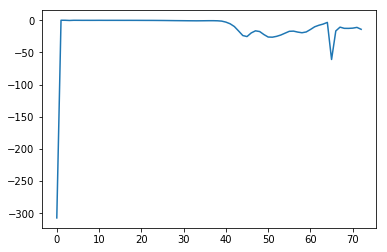

In [77]:
x,y = validation_generator[0]
y0 = M.predict(x)
validation_generator.max_b = 50
y0=np.expand_dims(y0,axis=-1)
plt.plot(y0[0]);

### M1

In [156]:
#Give bias, then 72 cumulative
M.load_weights('SavedModels/20190801150335Unet_Cumulative_Direct')
def Loss0(y,y0):
    A = mean_squared_error( -K.cumsum(y0[:,1:], axis=-1), -y[:, 1:])
    B = mean_squared_error(y[:,0], y0[:,0])
    return A+B

l=[]
for i, (x,y) in enumerate(validation_generator):
    y0 = M.predict(x)
    l.append(K.get_value(Loss0(y,y0)))
l=np.array(l)

### M2

In [169]:
#Direct pred
M.load_weights('SavedModels/20190801150335Unet_Cumulative_Direct')
x,y=train_generator[0]

def Loss1(y,y0):
    A = mean_squared_error(y[:,1:], y0[:,1:])
    B = mean_squared_error(y[:,0], y0[:,0])
    return A+B

l=[]
for i, (x,y) in enumerate(validation_generator):
    y0 = M.predict(x)
    l.append(K.get_value(Loss1(y,y0)))
l=np.array(l)

### M3

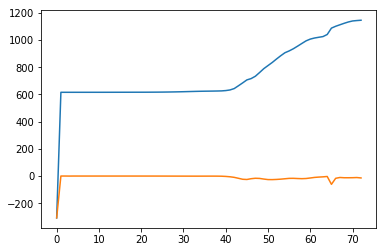

In [176]:
#Give bias, then 72 Diff
M.load_weights('SavedModels/20190801101233Unet_Cumulative_Combine_Loss')
x,y = validation_generator[0]
y0 = M.predict(x)


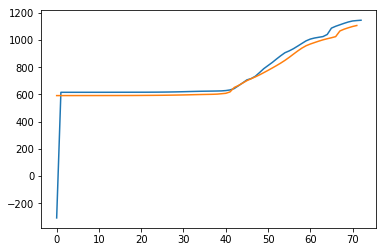

In [189]:
plt.plot(y[0])
plt.plot(-np.cumsum(y0[10,1:])- 2*y[10,0]);

In [182]:
y0[0,0]

-307.34546

In [14]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

#def Up_Down_loss(y_true, y_pred):
#    E = flxd_loss(y_true, y_pred)
#    E += flxu_loss(y_true, y_pred)
#    return E

######### DUAL LOSS
def bias_loss(y_true, y_pred):
    y_pred[:,-1]
    return mean_squared_error(y_true[:,0], y_pred[:,0])

def Up_Down_loss(y_true, y_pred):
    return mean_squared_error(y_true[:,1:], y_pred[:,1:])

def Cum_Down_No_bias(y_true, y_pred):
    return mean_squared_error(K.cumsum(y_true[:,1:], axis=-1),
                              K.cumsum(y_pred[:,1:], axis=-1))

def Total_Loss(y_true, y_pred):
    return Up_Down_loss(y_true, y_pred) + bias_loss(y_true, y_pred)

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, restore_best_weights=True)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'UNet_Double'
#archi = 'Fconv'
#M.load_weights('TrainedModels/20190719163900Unet_cum')
LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss', 'Up_Down_loss', 'bias_loss'])#, 'lambda_1_loss', 'model_2_loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
M.compile(loss = Total_Loss, optimizer=Adam, metrics=[Up_Down_loss, bias_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 72, 10)            0         
_________________________________________________________________
model_2 (Model)              (None, 73)                2505275   
Total params: 2,505,275
Trainable params: 2,505,275
Non-trainable params: 0
_________________________________________________________________


In [15]:
history=M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[ES, LH], shuffle=False, epochs=50)

Epoch 1/50
3888/3888 [==============================] - 213s 55ms/step - loss: 12464.9311 - Up_Down_loss: 10998.0769 - bias_loss: 1466.8537 - val_loss: 2200.7022 - val_Up_Down_loss: 1760.5773 - val_bias_loss: 440.1240
Epoch 2/50
3888/3888 [==============================] - 226s 58ms/step - loss: 1098.8857 - Up_Down_loss: 880.9012 - bias_loss: 217.9836 - val_loss: 1162.0732 - val_Up_Down_loss: 954.6918 - val_bias_loss: 207.3805
Epoch 3/50
3888/3888 [==============================] - 231s 60ms/step - loss: 856.9361 - Up_Down_loss: 673.0305 - bias_loss: 183.9046 - val_loss: 727.7799 - val_Up_Down_loss: 575.6028 - val_bias_loss: 152.1762
Epoch 4/50
3888/3888 [==============================] - 232s 60ms/step - loss: 750.4081 - Up_Down_loss: 586.9265 - bias_loss: 163.4807 - val_loss: 1045.1185 - val_Up_Down_loss: 803.3965 - val_bias_loss: 241.7211
Epoch 5/50
3888/3888 [==============================] - 236s 61ms/step - loss: 674.6336 - Up_Down_loss: 525.2187 - bias_loss: 149.4140 - val_loss:

In [16]:
print('Done')

Done


In [13]:
from generator import Preprocessed_Generator
P = Preprocessed_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0,shuffle=0, custom_b_p_e=0)
P2 = FLX_Cumulative_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0,shuffle=0, custom_b_p_e=0)
x,y = P[0]
x1,y1 = P2[0]

Restart - to file 0
Restart - to file 0


In [17]:
# IMPORTANT MODEL LOG SAVER
archi='Unet_Cumulative_Direct'
file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_unet)
        print('list_of_kernel_unet = ',list_of_kernel_unet)
        print('list_of_activations_unet = ', list_of_activations_unet)
        print('list_of_dropout = ', list_of_dropout)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])
        print(history.history)

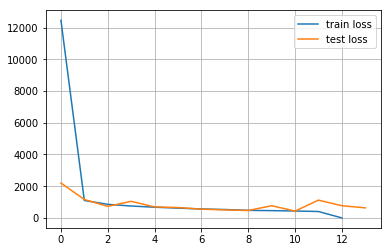

In [18]:
flxu_loss_h = LH.losses['loss'][1:-1].copy()
flxu_loss_h[-1]/=LH.frequency
#flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxu_loss_h)
ax.plot(history.history['val_loss'])
#ax.plot(flxd_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['train loss', 'test loss'])

In [39]:
#FP2 = D + Klist + D2 + V
#validation_generator = FLX_Generator(folder='Data4', batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)
#validation_generator.batch_size = validation_generator.batch_size*validation_generator.batch_per_file
#validation_generator.batch_per_filef
F_mse=[]
for i, (x,y) in enumerate(validation_generator):
    print(i/len(validation_generator)*100)
    y0 = M.predict(x)
    F_mse.append(K.get_value(Up_Down_loss(y,y0)))
F_mse=np.array(F_mse)

0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4000000000000001
1.6
1.7999999999999998
2.0
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.5999999999999996
3.8
4.0
4.2
4.3999999999999995
4.6
4.8
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.199999999999999
7.3999999999999995
7.6
7.8
8.0
8.200000000000001
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.799999999999999
12.0
12.2
12.4
12.6
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8


KeyboardInterrupt: 

In [27]:
from utils import F_and_plots, Plot_diff

x, y = validation_generator[51]
y0 = M.predict(x)

In [28]:
y=np.expand_dims(y,axis=-1)
y0=np.expand_dims(y0,axis=-1)

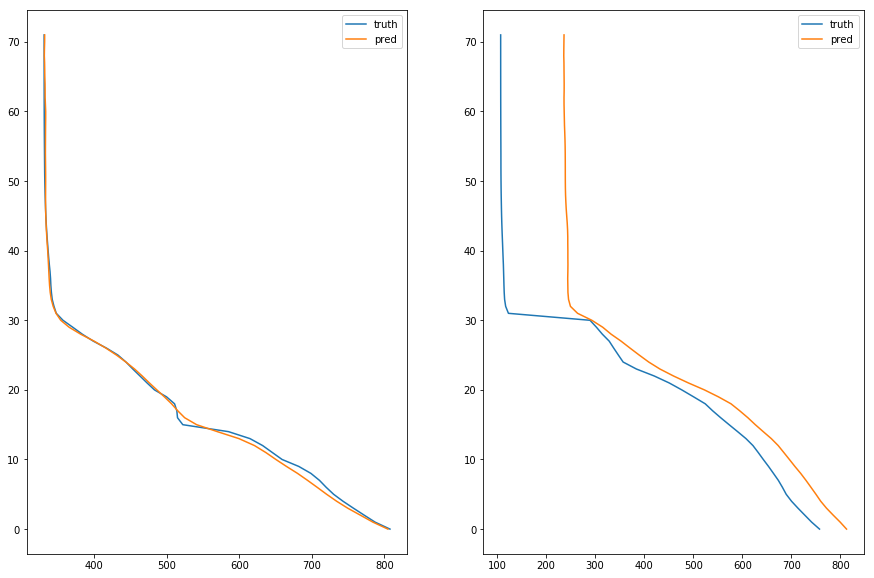

In [29]:
F = F_and_plots(shape=(1,2))
Plot_diff(F, y[:,1:]+y[:,0,0], y0[:,1:]+y0[:,0,0],header_y=['flx'], J=[0,1])

In [30]:
yc = np.cumsum(y[:,1:], axis=1)
y0c = np.cumsum(y0[:,1:], axis=1)
F = F_and_plots(shape=(1,2))
Plot_diff(F, yc, y0c,header_y=['flx'], J=[0,1])

TypeError: load_weights() missing 1 required positional argument: 'filepath'

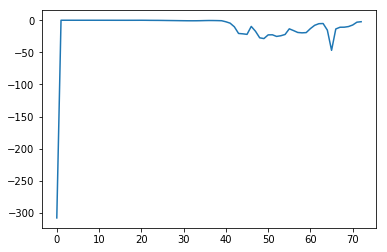

In [29]:
M.load_weights()


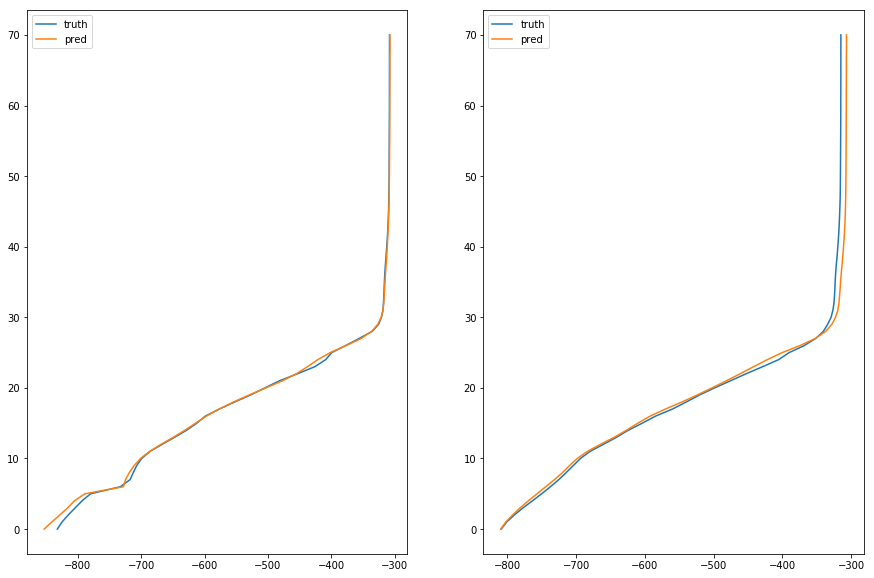

In [24]:
yc = np.cumsum(y[:,:-1], axis=1)
y0c = np.cumsum(y0[:,:-1], axis=1)

F = F_and_plots(shape=(1,2))
Plot_diff(F, yc[:,:-1], y0c[:,:-1],header_y=['flx'], J=[0,1])

In [85]:
l1=[]
for x,_ in validation_generator:
    l1.append(x[0,-1,-1])
validation_generator.on_epoch_end()
l2=[]
for x,_ in validation_generator:
    l2.append(x[0,-1,-1])
l1=np.array(l1)
l2=np.array(l2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


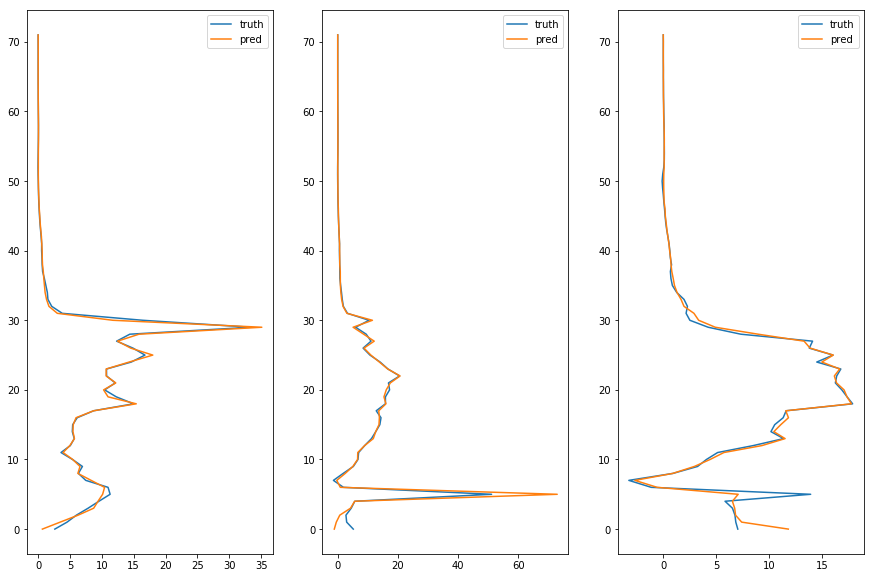

In [37]:
from utils import F_and_plots, Plot_diff
x,y = validation_generator[0]
y0 = M.predict(x)

J=[0,1,2]
F = F_and_plots(shape=(1,3))
y_0 = np.expand_dims(y0[[J]], axis=-1)
y_t = np.expand_dims(y[[J]], axis=-1)
Plot_diff(F, y_t, y_0, header_y=['flx'], J=J)

In [100]:
y_0.shape

(72, 2, 1)

from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, _ in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(y0)
    MSE = np.array(MSE)
    return(MSE)

train_generator =  Full_Diff_Generator(folder='Data2/', 
                                       batch_size=train_generator.batch_per_file*train_generator.batch_size,
                                       train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('pred_best_Unet_serveur',V)

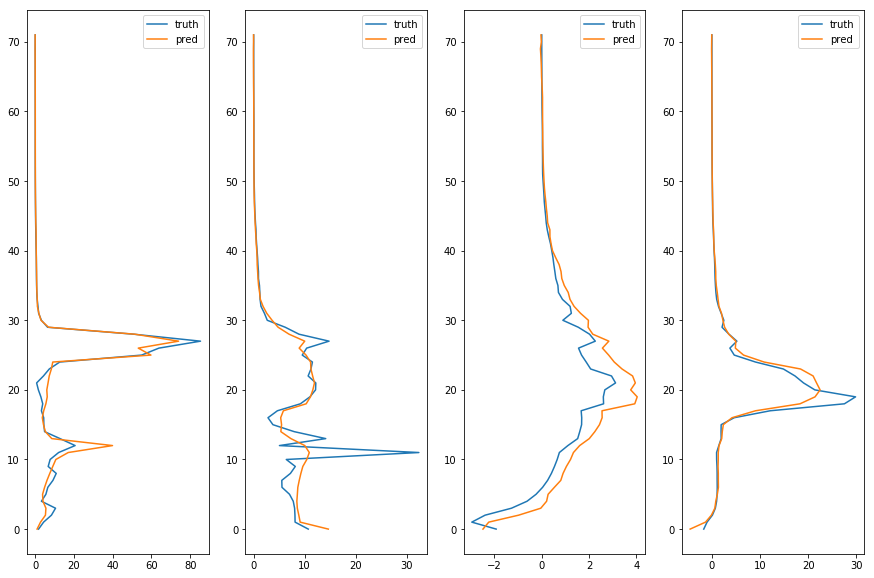

In [18]:
from utils import F_and_plots, Plot_diff
#M.load_weights('BestModels/Best_Unet(serveur)')

i=np.random.randint(len(validation_generator))
x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

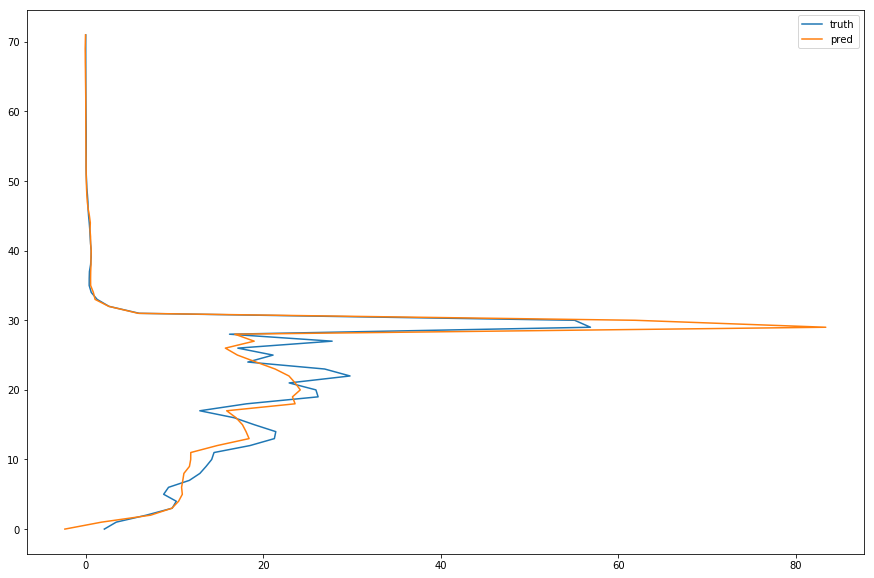

In [19]:
Plot_diff( F_and_plots(shape=(1,1)), y,y0, header_y=['flx'], J=[4])

In [17]:
MSE_e=K.get_value(Up_Down_loss(y,y0))
MSE_e = np.mean(MSE_e, axis=1)
np.argmin(MSE_e)

6

In [24]:
validation_generator.batch_size = int(validation_generator.batch_per_file*validation_generator.batch_size)
train_generator.batch_size = int(train_generator.batch_per_file*train_generator.batch_size)

In [19]:
X,Y = validation_generator[0]
Y0 = M.predict(X)
MSE_e = K.get_value(Up_Down_loss(Y0,Y))

In [22]:
for x,y in train_generator[0]

2.0365567

In [33]:
MSE_e.shape

(124416,)

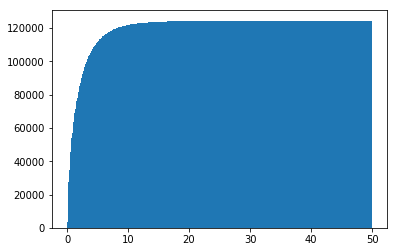

In [35]:
plt.hist(MSE_e, bins=500, cumulative=True);

In [ ]:
X,Y = validation_generator[0]
Y0 = M.predict(X)
MSE_e = K.get_value(Up_Down_loss(Y0,Y))
del(X,Y)
y_argmin = np.argmin(MSE_e)
validation_generator.batch_size = 32
x,y = validation_generator[y_argmin//32]
y0 = M.predict(x)
m = K.get_value(Up_Down_loss(y,y0))
xmin = x[[np.argmin(m)]]

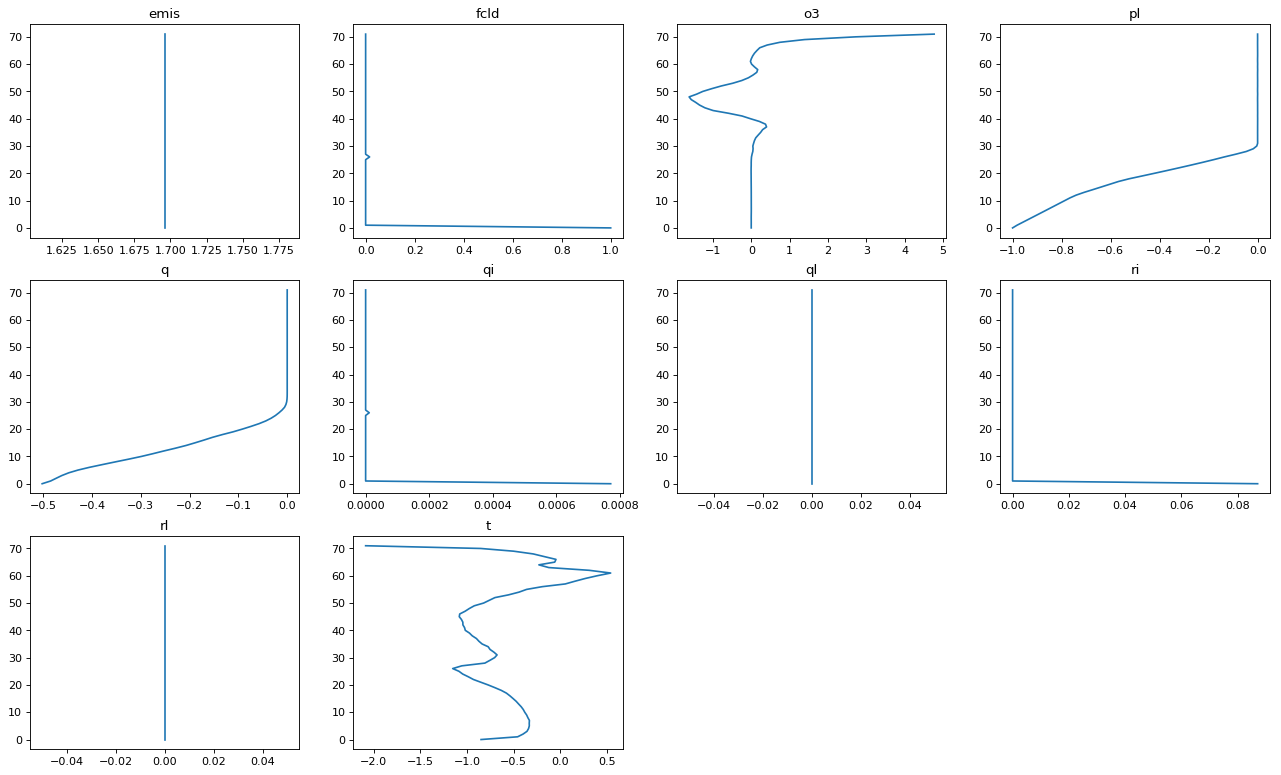

In [20]:
Plot_Batch(xmin, header_x)

In [24]:
def Jacobian(M,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = np.zeros((lev*n_var, lev))
    # could be more optimize [l steps instead of l*n_var]
    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            x0[0,l , v] += 1/dt
            P0[v*lev+l] = M.predict(x0)
    P1 = M.predict(x)
#    print(P0[0] - P1[0])
    return (P1-P0).T

J = Jacobian(M, xmin, 10000)

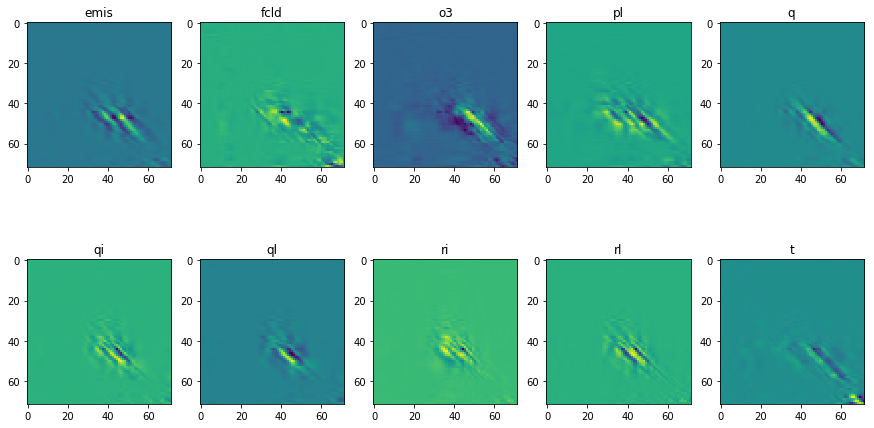

In [26]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,J, header_x)
J2 = Divide(J, header_x)

In [27]:
for i in J2:
    print(np.max(i), np.min(i))

0.0003237724304199219 -0.00021457672119140625
0.000232696533203125 -0.0003876686096191406
0.00014138221740722656 -6.794929504394531e-05
0.00017452239990234375 -0.00024962425231933594
0.0031156539916992188 -0.002803802490234375
0.0018143653869628906 -0.003237485885620117
0.0139923095703125 -0.011138439178466797
0.00028443336486816406 -0.0006031990051269531
0.0007419586181640625 -0.0012843608856201172
0.00020444393157958984 -0.0002016127109527588


In [29]:
import tqdm
G=[]
for i in tqdm.tqdm(range(72)):
    gradients = K.gradients(M.get_output_at(0)[:,i],M.input)
    gradients_f = K.function( [M.input] , [gradients[0]] )
    G.append(gradients_f([x[[0]]])[0])

G=np.array(G)
G = G[:,0,:,:]
G0 = G.swapaxes(1,2)
G0 = G0.reshape(72,720)

100%|██████████| 72/72 [02:20<00:00,  3.06s/it]


In [27]:
G0 = np.load('Tf_grad_best_model.npy')

In [29]:
from utils import Sep_Var_show, Sep_Var_Gradient

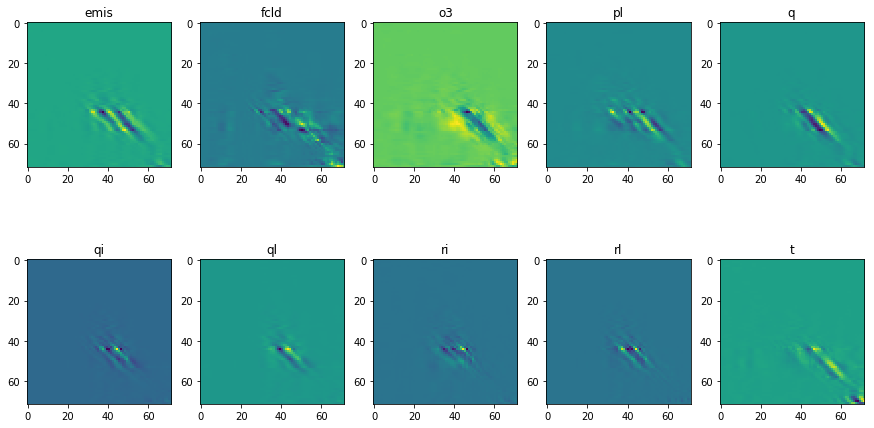

In [30]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,G0, header_x)

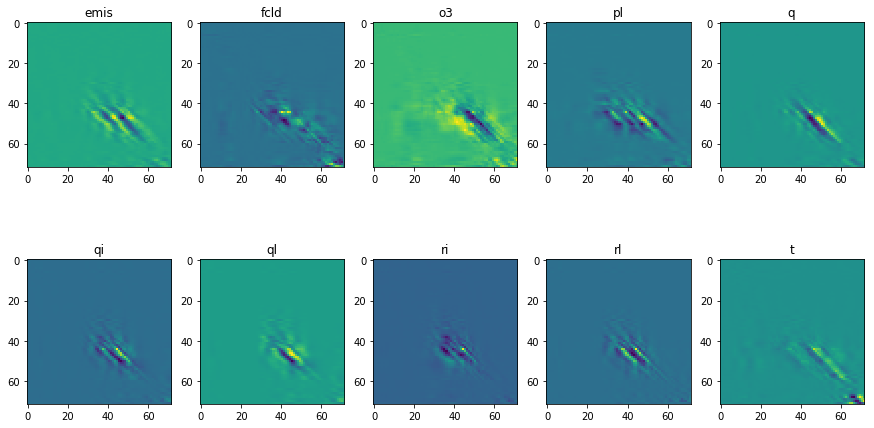

In [32]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,-J, header_x)

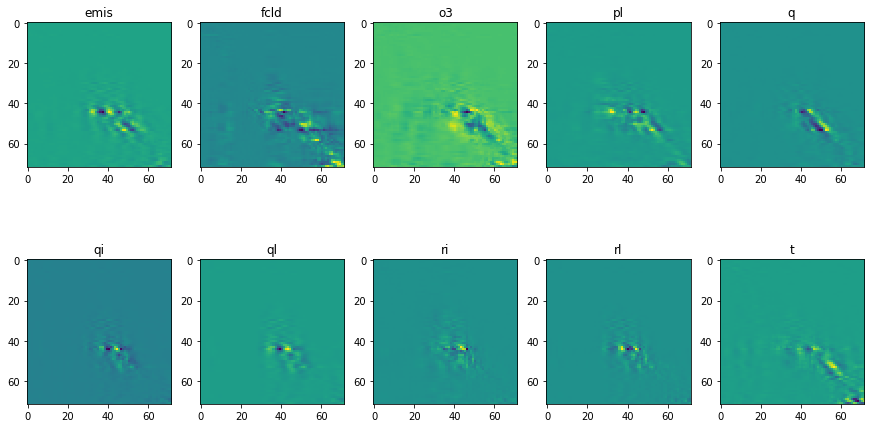

In [33]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,10000*J+G0, header_x)

In [52]:
for j,i in enumerate(G2-J2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4753172397613525 -5.038313627243042
fcld 4.450602293014526 -3.2322890758514404
o3 0.9157004952430725 -2.905653238296509
pl 4.1315600872039795 -3.7754268646240234
q 49.70502281188965 -54.84940028190613
qi 69.43060564994812 -36.00625824928284
ql 247.81062531471252 -280.3574583530426
ri 9.647634029388428 -5.988334655761719
rl 25.624382734298706 -15.990925073623657
t 3.0675272941589355 -4.052147626876831


In [49]:
for j,i in enumerate(G2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4751897 -5.038152
fcld 4.450342 -3.2321835
o3 0.91567427 -2.9055223
pl 4.131408 -3.7752972
q 49.702225 -54.847145
qi 69.42737 -36.005356
ql 247.80237 -280.35013
ri 9.647031 -5.988172
rl 25.623098 -15.990633
t 3.0673404 -4.051973


In [50]:
for j,i in enumerate(J2*10000):
    print(header_x[j], np.max(i), np.min(i))

emis 3.2377243041992188 -2.1457672119140625
fcld 2.32696533203125 -3.8766860961914062
o3 1.4138221740722656 -0.6794929504394531
pl 1.7452239990234375 -2.4962425231933594
q 31.156539916992188 -28.03802490234375
qi 18.143653869628906 -32.37485885620117
ql 139.923095703125 -111.38439178466797
ri 2.8443336486816406 -6.031990051269531
rl 7.419586181640625 -12.843608856201172
t 2.0444393157958984 -2.016127109527588


In [47]:
from generator import Full_Diff_Generator
test_gen = Full_Diff_Generator(folder='Data3', batch_size=batch_size, train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
test_gen.list_files = [24]

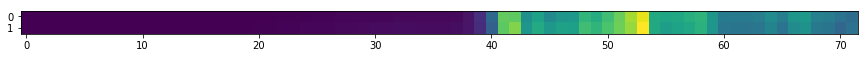

In [50]:
import tensorflow as tf
# CHECKING IMPACT OF LOWER LAYER
x,y = test_gen[100]

y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('linear_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
#Last_layer = K.function( [i1],[o4])
Last_layer = K.function( [i1],[o5])


#img = Dense_layer(First_model([x]))[0]
img = Last_layer( Up_model([x]))[0]

#Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))
#F = K.function(I,O)
#F([tf.cast(x,tf.float32)])

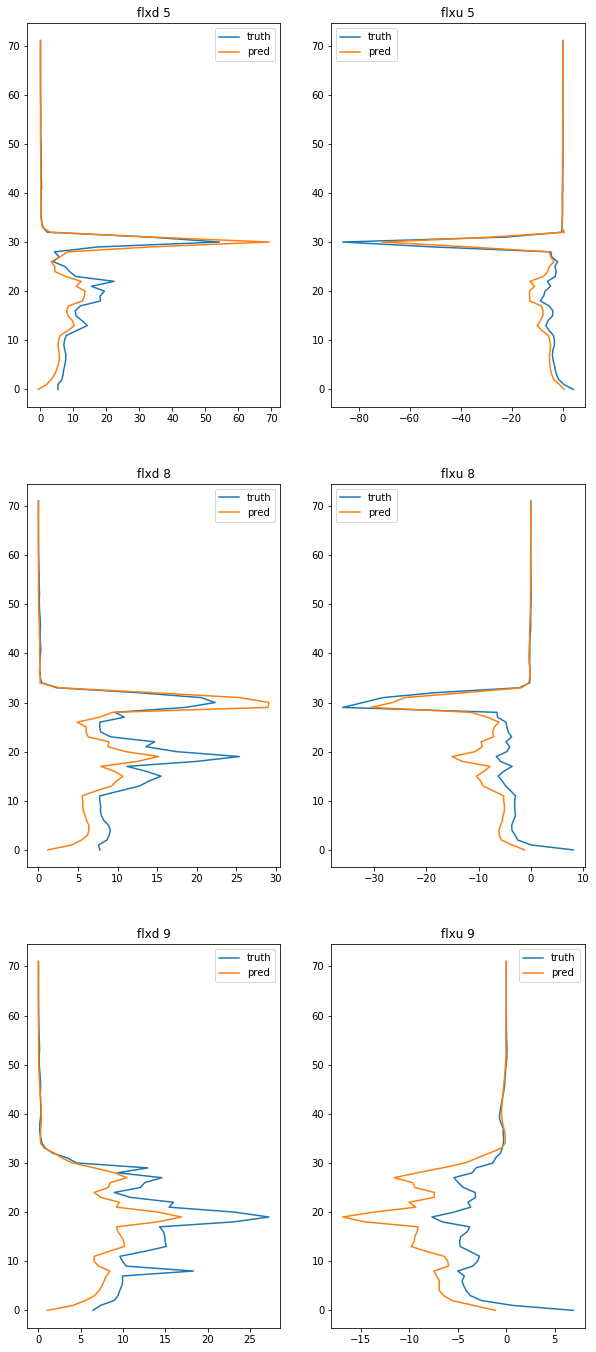

In [76]:
def Plot_diff(F, y,y0, header_y, lev=72, J = [0], titles=False):
    for l in range(len(header_y)):
        for ind,i in enumerate(J):
            F[ind*len(header_y) + l].plot(np.flip(y[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].plot(np.flip(y0[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].legend(["truth", "pred"])
            if titles !=False:
                F[ind*len(header_y) + l].set_title(header_y[l] + ' '+ str(titles[ind]))
                

J=[5,8,9]
F = F_and_plots(figsize=(5*2,len(J)*8), shape=(len(J), 2))
Plot_diff(F, y, img, ['flxd', 'flxu'], J=J, titles=J)

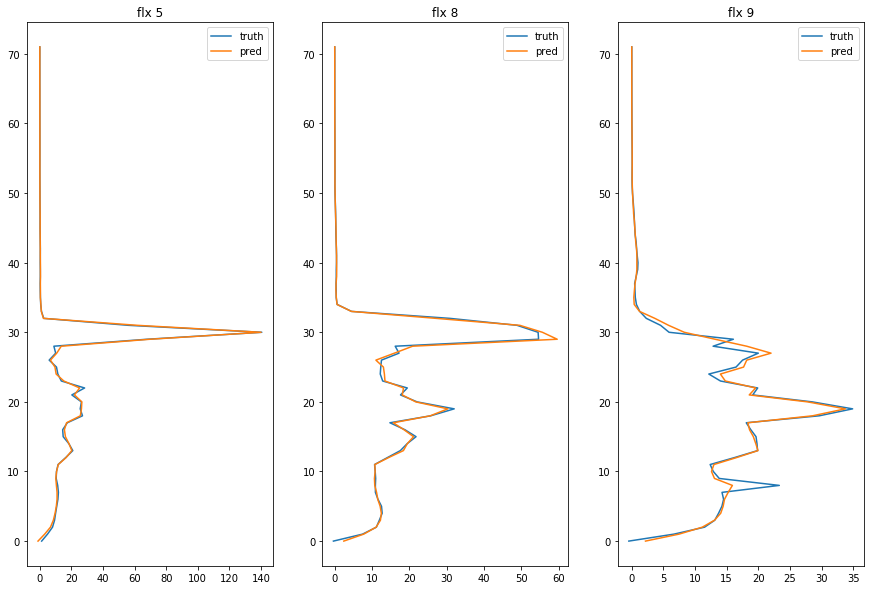

In [73]:
F = F_and_plots(figsize=(15,10), shape=(1,len(J)))
Plot_diff(F, y[:,:,[0]]-y[:,:,[1]], y0.reshape(32,72,1), ['flx'], J=J, titles=J)

In [70]:
y0.shape

(32, 72)